## Background

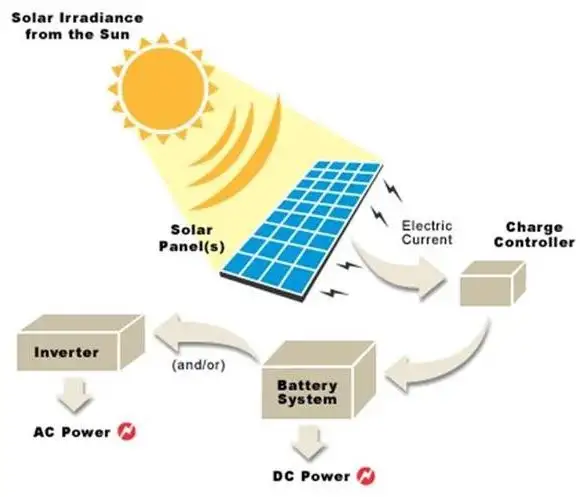

## Dataset

This dataset has two sets of files. Each set has two files.

 1. **Power Generation Data:** Data collected by inverters at inverter level
 
 2. **Weather Data:** Weather data collected by sensors at plant level

## Power Generation Dataset

 `DATE_TIME:` 15 minutes timestamp for a 34 day period
 
 `PLANT_ID:` Each plant has its unique ID that remains constant  
 
 `SOURCE_KEY:` Unique ID for each inverter
 
 `DC_POWER:` DC power received by an inverter for a timestamp
 
 `AC_POWER:` DC power converted to AC power by an inverter for a timestamp
 
 `DAILY_YIELD:` Cummulative sum of power generated, on a day, till that point of time
 
 `TOTAL_YIELD:` Total yield for an inverter till that point of time
        

## Weather Dataset

 `DATE_TIME:` 15 minutes timestamp for a 34 day period
 
 `PLANT_ID:` Each plant has its unique ID that remains constant  
 
 `SOURCE_KEY:` Unique ID for sensor
 
 `AMBIENT_TEMPERATURE:` Ambient temperature at the plant
 
 `MODULE_TEMPERATURE:` Temperature of the module (solar panel)
 
 `IRRADIATION:` Amount of irradiation for a timestamp

## Dependencies

In [5]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

# Models and Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Dataset

## Plant Generation Data
df_gen = pd.read_csv('Plant_Generation_Data.csv')

## Weather Data
df_wthr = pd.read_csv('Plant_Weather_Sensor_Data.csv')

In [11]:
df_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [12]:
df_wthr.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


## Data Description and Overview

In [13]:
df_gen.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09


Solar panels generate DC power however our systems run on AC power so when the DC power is converted to AC power, some part of it is lost due to losses in conversion. Therefore, AC power is lower than the DC power.

In [14]:
df_wthr.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3259.0,3259.000000,3259.000000,3259.000000
mean,4136001.0,28.069400,32.772408,0.232737
std,0.0,4.061556,11.344034,0.312693
min,4136001.0,20.942385,20.265123,0.000000
25%,4136001.0,24.602135,23.716881,0.000000
50%,4136001.0,26.981263,27.534606,0.019040
75%,4136001.0,31.056757,40.480653,0.438717
max,4136001.0,39.181638,66.635953,1.098766


There is a big difference between the 75th percentile and the maximum values of both ambient and module temperature. This indicates that the distribution is positively skewed.

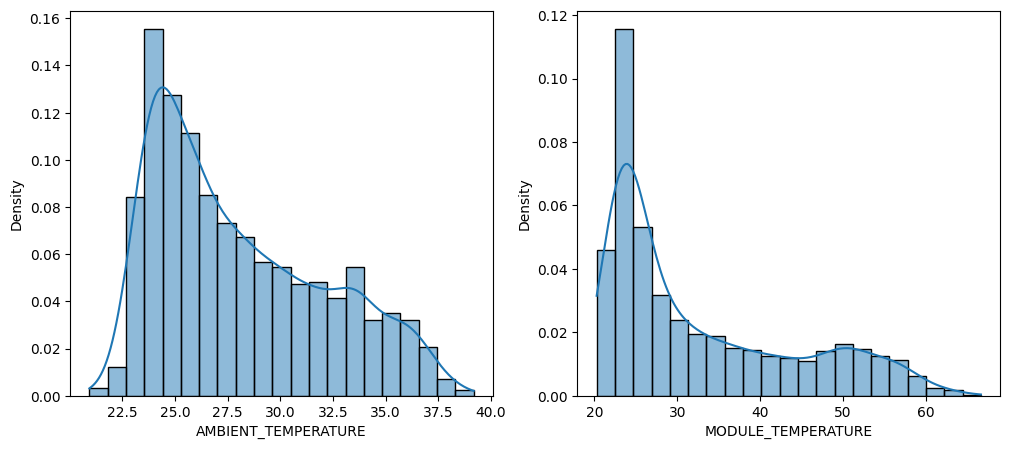

In [15]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_wthr.AMBIENT_TEMPERATURE, kde= True, stat = 'density',ax = ax1)
sns.histplot(df_wthr.MODULE_TEMPERATURE, kde= True, stat = 'density',ax = ax2)
plt.show()

These distributions illustrate that the ambient temperature rarely go above 35.

The higher temperature value would be during the day time on a bright sunny day and the lower value point out either night time
or a cloudy day.

Also, if we take a look at the left figure we can see that the most common temperature value is between 23-24, and then there is
a bump at around 33-34 degrees. Both these facts indicate shorter solar hours.

In [16]:
# Missing value information
print('No. of unique plant IDs (gen data):', df_gen.PLANT_ID.nunique())
print('No. of unique plant IDs (weather data):', df_wthr.PLANT_ID.nunique())
print('No. of (unique) invertors:', df_gen.SOURCE_KEY.nunique())
print('No. of sensors for weather data:', df_wthr.SOURCE_KEY.nunique())
print(f'\nMissing/Null values in generation dataset\n\n{df_gen.isnull().sum()}')
print(f'\nMissing/Null values in weather dataset\n\n{df_wthr.isnull().sum()}')

No. of unique plant IDs (gen data): 1
No. of unique plant IDs (weather data): 1
No. of (unique) invertors: 22
No. of sensors for weather data: 1

Missing/Null values in generation dataset

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

Missing/Null values in weather dataset

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


1. The plant id is the same for all the observations in both dataset.

2. The source key is same for all the observations in weather dataset which shows that all the readings have been taken by a single sensor. The source key for this dataset can be dropped.

3. There are a total of 22 different source keys in generation dataset and each source key represent a different inverter in this
plant.

4. There are no missing values in either of the dataset.

5. As the aim of this project is to predict genreation so we can drop the daily yield and total yield columns as well. These 
columns might be interesting for tasks like fault detection and maintenance predictions but not for our task.

In [17]:
# Dropping ineffective columns
df_gen.drop('PLANT_ID', axis = 1,inplace = True)
df_wthr.drop('PLANT_ID', axis = 1,inplace = True)
df_wthr.drop('SOURCE_KEY',axis =1, inplace = True)

# mapping the source key column in generation dataset
inv_lbl = {inv_name: inv_no for inv_no, inv_name in enumerate(df_gen.SOURCE_KEY.unique(),1)}
df_gen['INV_NUM'] = df_gen.SOURCE_KEY.map(inv_lbl)

df_gen.drop('SOURCE_KEY', axis=1, inplace = True)

df_gen = df_gen[['DATE_TIME', 'INV_NUM','DC_POWER','AC_POWER']]
df_gen.head()

,DATE_TIME,INV_NUM,DC_POWER,AC_POWER
0,2020-05-15 00:00:00,1,0.0,0.0
1,2020-05-15 00:00:00,2,0.0,0.0
2,2020-05-15 00:00:00,3,0.0,0.0
3,2020-05-15 00:00:00,4,0.0,0.0
4,2020-05-15 00:00:00,5,0.0,0.0


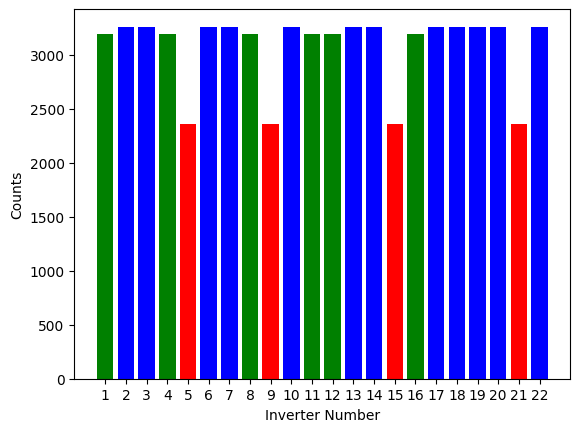

In [19]:
counts = df_gen.groupby('INV_NUM')['DATE_TIME'].count()
bar_color = [{c==2355: 'red', c==3195: 'green', c==3259: 'blue'}[True] for c in counts]
plt.bar(range(1,23), counts, color = bar_color)
plt.ylabel('Counts')
plt.xlabel('Inverter Number')
plt.xticks(range(1,23))
plt.show()

In [20]:
min_val = df_gen.groupby('INV_NUM')['DATE_TIME'].count().min()
max_val = df_gen.groupby('INV_NUM')['DATE_TIME'].count().max()
print(f'\nThe minimum number of recorded observations are {min_val}')
print(f'The maximum number of recorded observations are {max_val}')
print(f'The difference between the maximum and minimum observations is {max_val - min_val}')


The minimum number of recorded observations are 2355
The maximum number of recorded observations are 3259
The difference between the maximum and minimum observations is 904


In [21]:
inv_counts = df_gen.groupby('INV_NUM')['DATE_TIME'].count().reset_index()
pd.crosstab(inv_counts['DATE_TIME'],inv_counts['INV_NUM'])

INV_NUM,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2355,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3195,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3259,0,1,1,0,0,1,1,0,0,1,...,1,1,0,0,1,1,1,1,0,1


Some inverters have more values and some have less. For our analysis, we need values from all the inverters for each timestamp.
We can either impute the missing values or remove the extra rows. Removing the excess rows will lead to loss of significant amount of valuable data so imputation of the missing values seem a better option.

Right now, the data is inverter-wise however we want it to be day-wise (timestamp wise) for our model. We want to sum the `AC_Power` and `DC_POWER` from all the inverters for each timestamp.

## Data Reshaping

In [22]:
group_gen = df_gen.groupby(['INV_NUM'])
group_list = list()
for i in df_gen['INV_NUM'].unique():
    grouped_df = group_gen.get_group(i)
    grouped_df.columns = ['DATE_TIME',f'INV_NUM_{i}',f'DC_POWER_{i}',f'AC_POWER_{i}']
    group_list.append(grouped_df)
df_gen_new = reduce(lambda left, right: pd.merge(left,right, on= ['DATE_TIME'], how='outer'),group_list)
df_gen_new

,DATE_TIME,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,DC_POWER_2,AC_POWER_2,INV_NUM_3,DC_POWER_3,AC_POWER_3,...,AC_POWER_19,INV_NUM_20,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22
0,2020-05-15 00:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
1,2020-05-15 00:15:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
2,2020-05-15 00:30:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
3,2020-05-15 00:45:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
4,2020-05-15 01:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2020-05-20 13:00:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1179.653333,20,1299.906667,1267.406667,NaN,NaN,NaN,22,0.0,0.0
3255,2020-05-20 13:15:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1173.713333,20,1286.700000,1254.526667,NaN,NaN,NaN,22,0.0,0.0
3256,2020-05-20 13:30:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1116.450000,20,1224.671429,1194.050000,NaN,NaN,NaN,22,0.0,0.0
3257,2020-05-20 13:45:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1095.706667,20,1200.953333,1170.946667,NaN,NaN,NaN,22,0.0,0.0


A lot of null values have been introduced while trying to retain useful data and need to be imputed for analysis. This will be done in a later section. Now for ease of readability, the `DATE_TIME` column is divided into two seperate columns `DATE` and `TIME` and a new column `BLOCK` is created that represent the 15 minute timestamp of observations so each day has a total of 96 blocks. Further the `df_wthr` dataframe is merged with the `df_gen_new` dataframe to obtain a single dataset. 

In [23]:
# Merging df_gen_new and df_wthr
df = pd.merge(df_wthr,df_gen_new, on = 'DATE_TIME', how = 'inner')
df = df.sort_values(by = ['DATE_TIME']).reset_index(drop = True)
df['DATE'] = df['DATE_TIME'].apply(lambda x: x[:-9])
df['TIME'] = df['DATE_TIME'].apply(lambda x: x[-8:])
# df = df.sort_values(by = ['DATE','TIME']).reset_index(drop = True)

# Adding BLOCK column
times = np.sort( df['TIME'].unique())
block_dict = {time: block for block, time in enumerate(times,1)}
df['BLOCK'] = df['TIME'].map(block_dict)

# Dropping DATE_TIME column
df.drop('DATE_TIME', axis = 1, inplace = True)

# Re-ordering columns
cols = df.columns.tolist()
df = df[[cols[-1]] + [cols[-3]] + [cols[-2]] + cols[:-3]] 
df.head()

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,...,AC_POWER_19,INV_NUM_20,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22
0,1,2020-05-15,00:00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-05-15,00:15:00,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-05-15,00:30:00,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-05-15,00:45:00,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-05-15,01:00:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


## Train Test Split

Instead of random splitting, for the sake of continuity, the data for the last three days is selected for testing. The rest of the data is used for training the model.

In [24]:
df.tail()

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,...,AC_POWER_19,INV_NUM_20,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22
3254,92,2020-06-17,22:45:00,23.511703,22.856201,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3255,93,2020-06-17,23:00:00,23.482282,22.744190,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3256,94,2020-06-17,23:15:00,23.354743,22.492245,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3257,95,2020-06-17,23:30:00,23.291048,22.373909,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3258,96,2020-06-17,23:45:00,23.202871,22.535908,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [25]:
test_date = df['DATE'].unique()[-3:]
test_date

array(['2020-06-15', '2020-06-16', '2020-06-17'], dtype=object)

In [26]:
df_test = df[df['DATE'].isin(test_date)].reset_index(drop = True)
df_test

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,...,AC_POWER_19,INV_NUM_20,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22
0,1,2020-06-15,00:00:00,24.486876,23.846251,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-06-15,00:15:00,24.509378,23.902851,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-06-15,00:30:00,24.605338,24.172737,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-06-15,00:45:00,24.679791,24.459142,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-06-15,01:00:00,24.636373,24.380419,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,92,2020-06-17,22:45:00,23.511703,22.856201,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
284,93,2020-06-17,23:00:00,23.482282,22.744190,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
285,94,2020-06-17,23:15:00,23.354743,22.492245,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
286,95,2020-06-17,23:30:00,23.291048,22.373909,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [27]:
df_train = df[~df['DATE'].isin(test_date)]
df_train

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,...,AC_POWER_19,INV_NUM_20,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22
0,1,2020-05-15,00:00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-05-15,00:15:00,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-05-15,00:30:00,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-05-15,00:45:00,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-05-15,01:00:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,92,2020-06-14,22:45:00,24.185657,22.922953,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2967,93,2020-06-14,23:00:00,24.412542,23.356136,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2968,94,2020-06-14,23:15:00,24.652915,23.913763,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2969,95,2020-06-14,23:30:00,24.702391,24.185130,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [25]:
df_train.to_csv('Training_data.csv')
df_test.to_csv('Testing_data.csv')

## Missing Data Imputation

In [28]:
print('Shape of training data: ',df_train.shape)
print('Shape of testing data: ',df_test.shape)
print(f'\nMissing values in training data:\n{df_train.isnull().sum().tolist()}')
print(f'\nMissing values in testing data:\n{df_test.isnull().sum().tolist()}')

Shape of training data:  (2971, 72)
Shape of testing data:  (288, 72)

Missing values in training data:
[0, 0, 0, 0, 0, 0, 64, 64, 64, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, 0, 0, 904, 904, 904, 64, 64, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 904, 904, 904, 0, 0, 0]

Missing values in testing data:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The testing data has no missing values however, the training data has some missing values that need to be imputed.

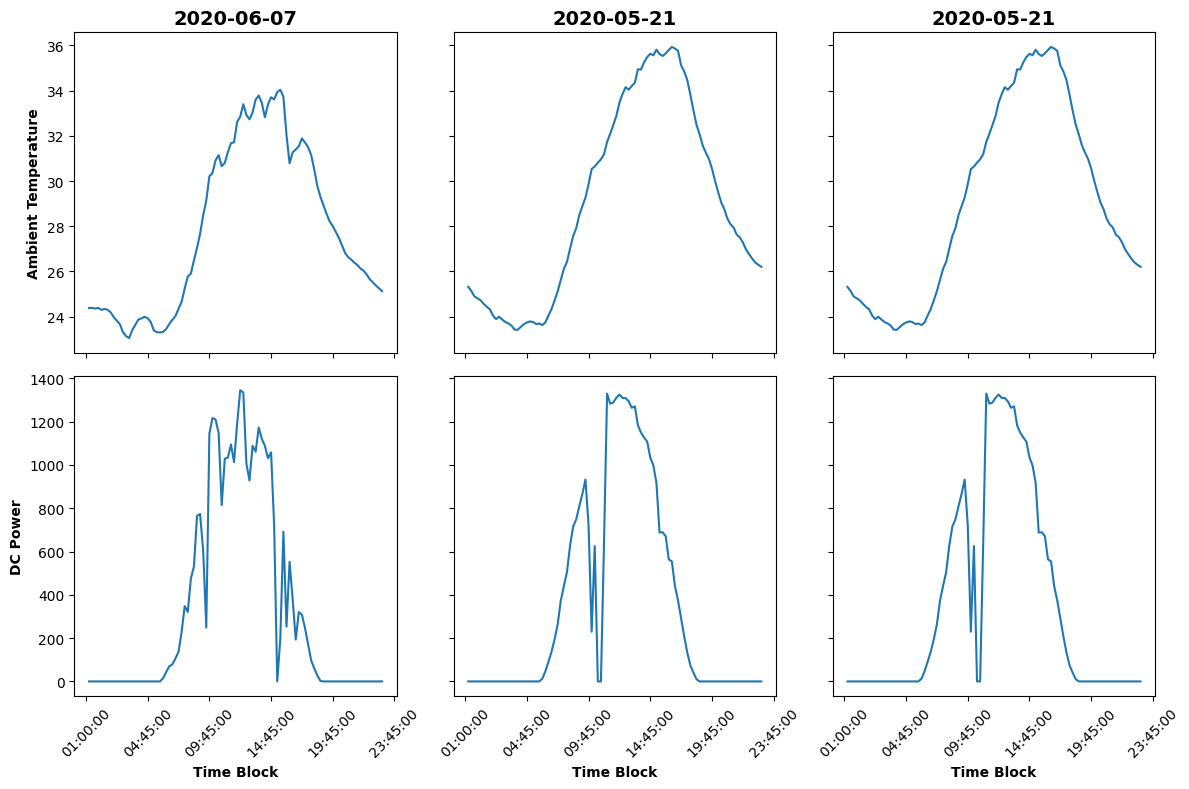

In [29]:
time_block = df_train[df_train['DATE']=='2020-05-18']['BLOCK']
time_list = [2,5,20,40,60,80,96]
time = df_train[(df_train['DATE']=='2020-05-18') & (df_train['BLOCK'].isin(time_list))]['TIME']

length = False
while not length:
    dates = df_train.DATE.sample(n=3, replace = False).tolist()
    temp_len = [len(df_train[df_train['DATE']==dates[i]]['AMBIENT_TEMPERATURE']) for i in range(3)]
    pow_len =  [len(df_train[df_train['DATE']==dates[i]]['DC_POWER_1']) for i in range(3)]
    tot_len = temp_len + pow_len
    len_chck = [i == 96 for i in tot_len]
    length = all(len_chck)

fig, axs = plt.subplots(2, 3, figsize=(12,8),sharey='row',sharex='col')
for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        if i ==0:
            ax.plot(time_block, df_train[df_train['DATE']==dates[j]]['AMBIENT_TEMPERATURE'])
            axs[0][0].set_ylabel('Ambient Temperature', fontweight = 'bold')
            ax.set_title(dates[j], fontsize = 14, fontweight = 'bold')

        else:
            ax.plot(time_block, df_train[df_train['DATE']==dates[j]]['DC_POWER_16'])
            axs[1][0].set_ylabel('DC Power', fontweight = 'bold')
            ax.set_xlabel('Time Block', fontweight = 'bold')


        ax.tick_params(axis='x', rotation=45)
        ax.set_xticklabels(time)

fig.tight_layout()
plt.show()        

From these graphs, it can be interpreted that the data is continuous and have sequential characteristics. The previous and the next timestamps play a role in the imputation of the missing values. Therefore, the train-test split was not random.

The data is not straight forward and therefore, each column cannot be imputed with the same technique. First of all, it should be noted that the solar energy is only available during day time (`soalr hours`). So, `IRRADIATION`, `DC_POWER`, and `AC_POWER` will be zero in non-solar hours. For non-solar hours, a value of zero will be imputed.

However, for solar hours the following strategy is adopted.

* `Linear:` Irradiation and Module temperature columns will be imputed by this technique


* `Polynomial:` A degree 2 polynomial spline will be used for DC and AC power columns

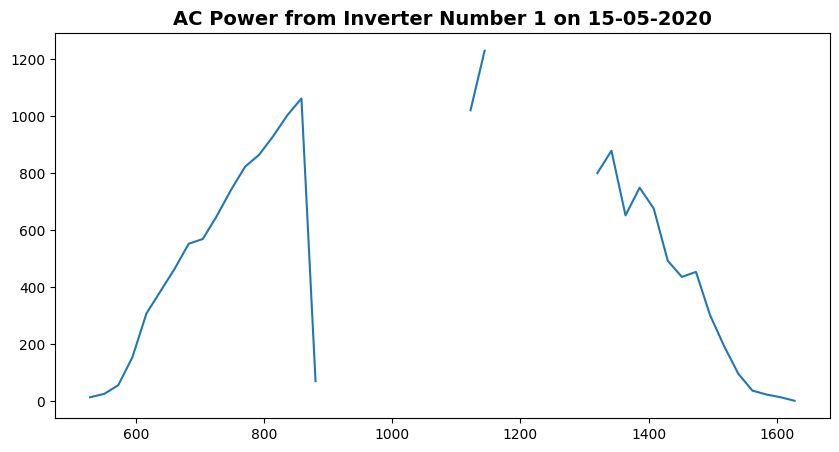

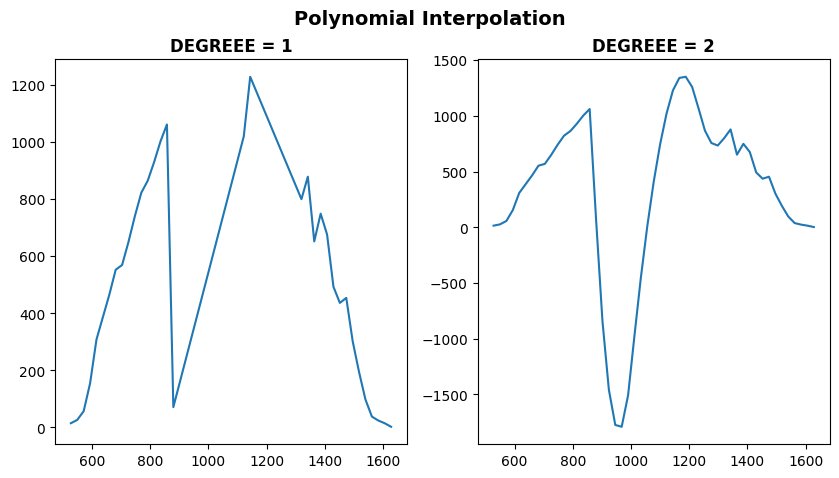

In [30]:
#Code for Plot 1
df2 = df_gen.copy() # Making a acopy 
df2['DATE'] = df2['DATE_TIME'].apply(lambda x: x[:-9])

## Selecting a date and replacing AC Power with NaN wherever its 0 and plotting 
indexes = df2[(df2['INV_NUM']==1)&(df2['DATE']=='2020-05-15')&(df2['AC_POWER']==0)].index
df2.loc[indexes,'AC_POWER']=np.nan
df2 = df2[(df2['INV_NUM']==1)&(df2['DATE']=='2020-05-15')]['AC_POWER']
fig1 = df2.plot(figsize=(10,5))
plt.title('AC Power from Inverter Number 1 on 15-05-2020', fontsize = 14, fontweight = 'bold')

#Code for Plot 2
## Comparison between 1 & 2 degree splines
fig2, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig2.suptitle('Polynomial Interpolation', fontsize = 14, fontweight = 'bold')
ax1.set_title('DEGREEE = 1', fontweight = 'bold')
ax2.set_title('DEGREEE = 2', fontweight = 'bold')
ax1.plot(df2.interpolate(method='polynomial',order=1))
ax2.plot(df2.interpolate(method='polynomial',order=2));

It can be seen from the above graphs that degree two spline is much more smoother than degree one spline which is required for the demand side management (DSM). DSM will not be covered in this project as it is out of the current scope. 

In [31]:
col_DC = [i for i in df.columns if 'DC_POWER' in i]
col_AC = [i for i in df.columns if 'AC_POWER' in i]
solar_cols = col_DC + col_AC +['IRRADIATION']

def transform_data(df):
    # Insert zero for non-solar hours (18:45 - 05:45)
    df1 = df.copy()
    solar_hours = (df1['BLOCK'] > 24) & (df1['BLOCK'] <76)
    for col in solar_cols:
        df1.loc[~(solar_hours),col] = 0
    
    # For solar hours, the zeros in the solar hours also need to be interpolated.
    
    # Converting zeros to nan 
    for col in solar_cols[:-1]:
        solar_hours = (df1['BLOCK'] > 24) & (df1['BLOCK'] <76) & (df1[col]==0)
        df1.loc[solar_hours,col] = np.nan
    
    # Interpolation of nan values in solar hours     
    df1[col_DC+col_AC].interpolate(method='polynomial',order = 2,inplace=True)  
    df1.interpolate(method='linear',inplace=True)
    
    # Summing up all inverter's AC and DC power values for each time stamp
    df1['AC_POWER'] = df1.loc[: ,col_AC].sum(axis=1)
    df1['DC_POWER'] = df1.loc[:,col_DC].sum(axis=1)
    
    #Scaling generation to MW from kW  
    df1['AC_POWER'] = df1['AC_POWER']/1000
    df1['DC_POWER'] = df1['DC_POWER']/1000

    return df1

In [32]:
df_train_trans = transform_data(df_train)
df_train_trans.to_csv('df_train_trans.csv')

df_test_trans = transform_data(df_test)
df_test_trans.to_csv('df_test_trans.csv')

## Exploratory Data Analysis

The data is ready on plant level for a timestamp of 15 minutes for 34 days. Exploratory analysis can be performed to extract useful insights about the data that will help in model generation. 

In [33]:
df_train_trans.head()

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_NUM_1,DC_POWER_1,AC_POWER_1,INV_NUM_2,...,DC_POWER_20,AC_POWER_20,INV_NUM_21,DC_POWER_21,AC_POWER_21,INV_NUM_22,DC_POWER_22,AC_POWER_22,AC_POWER,DC_POWER
0,1,2020-05-15,00:00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,0.0
1,2,2020-05-15,00:15:00,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,0.0
2,3,2020-05-15,00:30:00,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,0.0
3,4,2020-05-15,00:45:00,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,0.0
4,5,2020-05-15,01:00:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,0.0


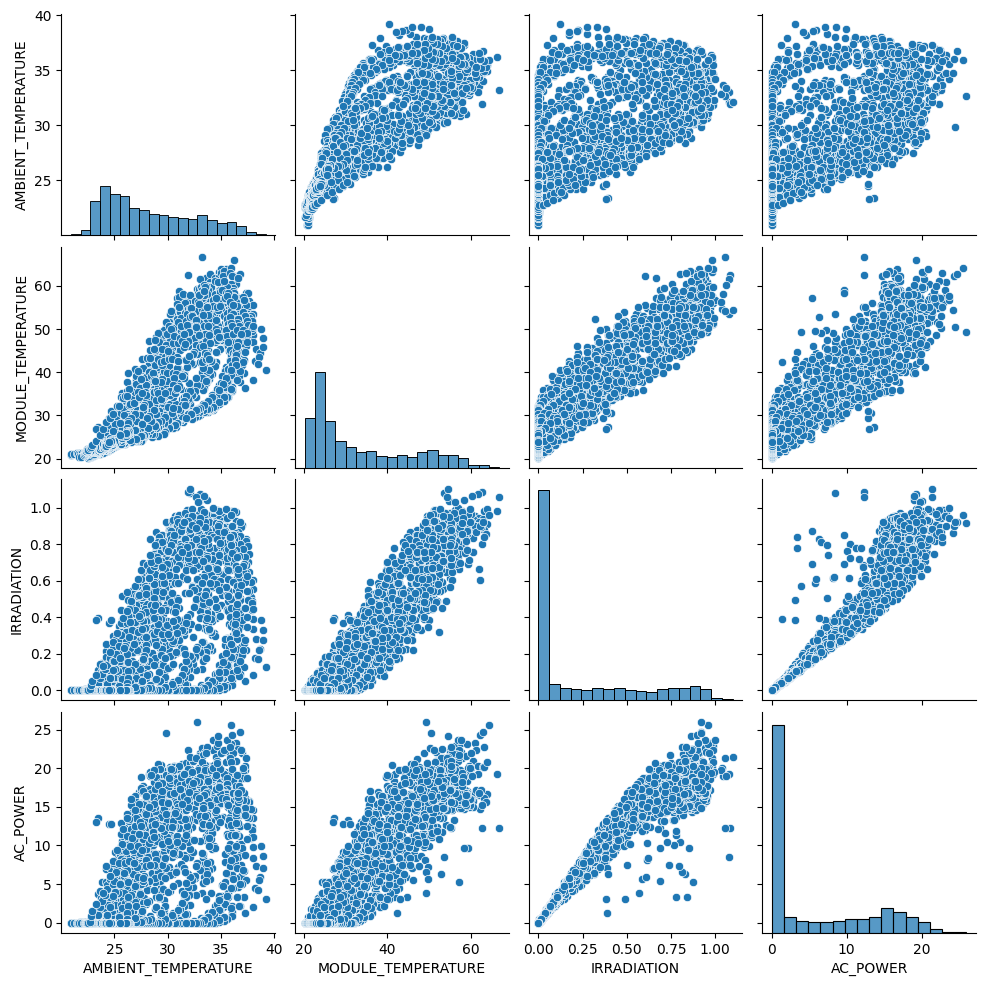

In [34]:
sns.pairplot(df_train_trans[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION','AC_POWER']])
plt.savefig('pairplot.png')

By looking at these graphs it can be inferred that

1. `Irradiation` has a strong linear relation with `AC Power` and `Module Temperature`.
2. The data distribution of `Irradiation` and `AC Power` is highly skewed due to zero values for approximately half of the timestamps (non-solar hours).
3. Increased variability in module temperature with increase in ambient temperature. This indicated that the module temperature might be influenced by other parameters like humidity, wind speed, etc.
4. Presence of outliers in `AC Power`

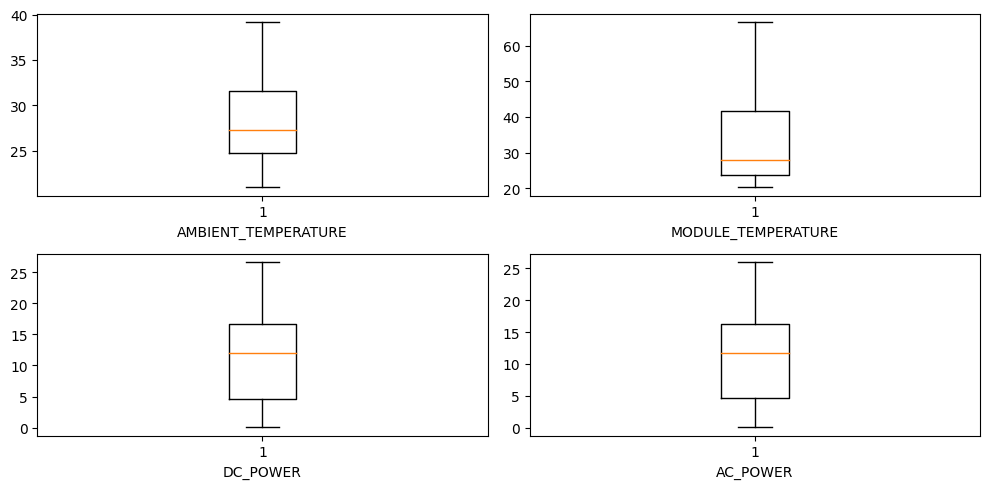

In [36]:
fig, axs = plt.subplots(2,2, figsize=(10,5))
cols = df_train_trans.columns[[3,4,-1,-2]]
for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        k = 2*i+j
        ax.boxplot(df_train_trans.loc[df_train_trans[cols[k]]!=0,cols[k]])
        ax.set_xlabel(cols[k])
plt.tight_layout()
plt.show()

In [37]:
df1 = df_train_trans[df_train_trans.columns[[0,1,2,3,4,5,-1,-2]]] 
corr = df1[df1.columns[[3,4,5,-1,-2]]].corr()
corr

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,AC_POWER,DC_POWER
AMBIENT_TEMPERATURE,1.000000,0.842631,0.660461,0.668544,0.668573
MODULE_TEMPERATURE,0.842631,1.000000,0.947143,0.923605,0.923866
IRRADIATION,0.660461,0.947143,1.000000,0.966009,0.966348
AC_POWER,0.668544,0.923605,0.966009,1.000000,0.999997
DC_POWER,0.668573,0.923866,0.966348,0.999997,1.000000


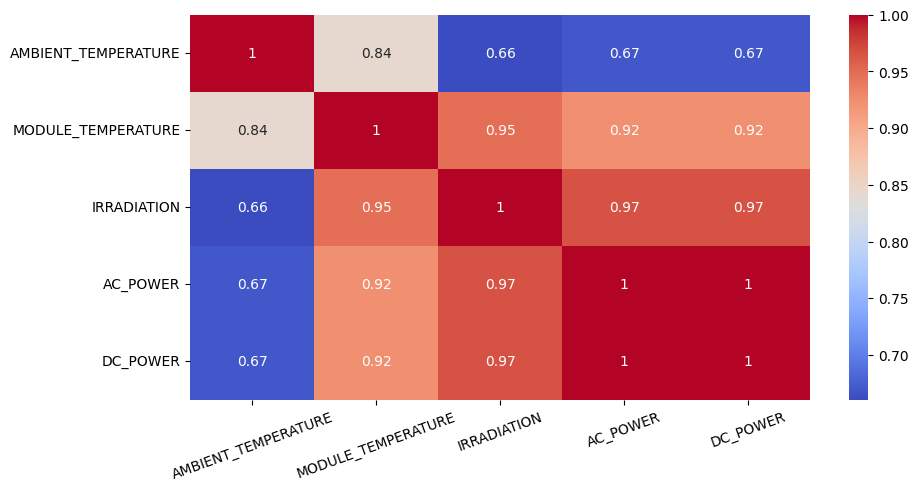

In [52]:
plt.figure(figsize = (10,5))
sns.heatmap(corr, annot = True,cmap="coolwarm")
plt.xticks(rotation=20)
plt.yticks(rotation=0)
plt.show()

The heat map and the correlation table prove the inferences made earlier. Additionally, they show that the ambient temperature has comparitively less significance in the prediction of the generation.

The most important parameter for the prediction of solar power generation is `IRRADIATION`. As AC_Power is practically derived from the DC_Power and also in real world, we are more interested in the AC_Power so DC_Power will be dropped for further analysis. 

## Handling Outliers

Handling outliers is one of the most important step in pre-processing. They can hamper the performance of the algorithm especially those algorithms which are based distance between data points such as linear regression, k-Means, etc.

In [53]:
# df1 = df1.drop('DC_POWER',axis = 1)
perc_dict = {}
for i in df1.columns[3:]:
    perc_list = []
    for j in [1,10,25,50,75,90,99,100]:
        perc_list.append(round(np.percentile(df1[i],j),2))
    perc_dict[i] = perc_list
df_perc = pd.DataFrame(perc_dict)
df_perc['Percentiles'] = [1,10,25,50,75,90,99,100]
per_cols = df_perc.columns.tolist()
df_perc= df_perc[[per_cols[-1]] + per_cols[:-1]]
df_perc

,Percentiles,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER
0,1,22.55,21.10,0.00,0.00,0.00
1,10,23.66,22.40,0.00,0.00,0.00
2,25,24.73,23.76,0.00,0.00,0.00
3,50,27.24,27.79,0.02,0.57,0.55
4,75,31.55,41.75,0.46,12.70,12.44
5,90,34.61,52.28,0.80,17.61,17.18
6,99,37.40,60.32,0.96,22.27,21.75
7,100,39.18,66.64,1.10,26.63,25.98


The values below first percentile and 99 percentile will be replaced by first and 99th percentile. 

In [54]:
df2 = df_test_trans[df_test_trans.columns[[0,1,2,3,4,5,-2]]]
df2.head()

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,AC_POWER
0,1,2020-06-15,00:00:00,24.486876,23.846251,0.0,0.0
1,2,2020-06-15,00:15:00,24.509378,23.902851,0.0,0.0
2,3,2020-06-15,00:30:00,24.605338,24.172737,0.0,0.0
3,4,2020-06-15,00:45:00,24.679791,24.459142,0.0,0.0
4,5,2020-06-15,01:00:00,24.636373,24.380419,0.0,0.0


In [55]:
def handle_outlier(df):
    dfc = df.copy()
    for i in dfc.columns[3:]:
        FIRST_PERC = np.percentile(dfc[i],1)
        NINE_NINE_PERC = np.percentile(dfc[i],99)
        
        dfc[i] = dfc[i].apply(lambda x: FIRST_PERC if (x < FIRST_PERC) else x)
        dfc[i] = dfc[i].apply(lambda x: NINE_NINE_PERC if (x > NINE_NINE_PERC) else x)
        
    return dfc

In [56]:
df_train_proc = handle_outlier(df1)
df_train_proc.to_csv('df_train_proc.csv')

df_test_proc = handle_outlier(df2)
df_test_proc.to_csv('df_test_proc.csv')

## Model Generation

For k-Fold Cross Validation, the data will be divided into 8 bins each day. Each bin will contain 12 timestamps.

In [57]:
# Number of bins per day
cut_blocks = range(1,9)

# Range of each bin 
cut_bins = range(0,97,12)

#Assigning each row to a bin based on BLOCKS
df_train_proc['BIN'] = pd.cut(df_train_proc['BLOCK'], bins=cut_bins, labels = cut_blocks)
df_train_proc

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,BIN
0,1,2020-05-15,00:00:00,27.004764,25.060789,0.0,0.0,0.0,1
1,2,2020-05-15,00:15:00,26.880811,24.421869,0.0,0.0,0.0,1
2,3,2020-05-15,00:30:00,26.682055,24.427290,0.0,0.0,0.0,1
3,4,2020-05-15,00:45:00,26.500589,24.420678,0.0,0.0,0.0,1
4,5,2020-05-15,01:00:00,26.596148,25.088210,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
2966,92,2020-06-14,22:45:00,24.185657,22.922953,0.0,0.0,0.0,8
2967,93,2020-06-14,23:00:00,24.412542,23.356136,0.0,0.0,0.0,8
2968,94,2020-06-14,23:15:00,24.652915,23.913763,0.0,0.0,0.0,8
2969,95,2020-06-14,23:30:00,24.702391,24.185130,0.0,0.0,0.0,8


In [58]:
#Assigning each row to a bin based on BLOCKS
df_test_proc['BIN'] = pd.cut(df_train_proc['BLOCK'], bins=cut_bins, labels = cut_blocks)
df_test_proc

,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,AC_POWER,BIN
0,1,2020-06-15,00:00:00,24.486876,23.846251,0.0,0.0,1
1,2,2020-06-15,00:15:00,24.509378,23.902851,0.0,0.0,1
2,3,2020-06-15,00:30:00,24.605338,24.172737,0.0,0.0,1
3,4,2020-06-15,00:45:00,24.679791,24.459142,0.0,0.0,1
4,5,2020-06-15,01:00:00,24.636373,24.380419,0.0,0.0,1
...,...,...,...,...,...,...,...,...
283,92,2020-06-17,22:45:00,23.511703,22.856201,0.0,0.0,8
284,93,2020-06-17,23:00:00,23.482282,22.744190,0.0,0.0,8
285,94,2020-06-17,23:15:00,23.354743,22.492245,0.0,0.0,8
286,95,2020-06-17,23:30:00,23.291048,22.373909,0.0,0.0,8


In [59]:
# Pipelines for different models

pipeline_lr = Pipeline([('scaler1',StandardScaler()), ('lin_regression',LinearRegression())])
pipeline_dt = Pipeline([('scaler2',StandardScaler()), ('dt_regression',DecisionTreeRegressor(random_state=22))])
pipeline_rf = Pipeline([('scaler3',StandardScaler()), ('rf_regression',RandomForestRegressor(random_state=22))])
pipeline_ridge = Pipeline([('scaler4',StandardScaler()), ('ridge_regression',Ridge(random_state=22))])
pipeline_lasso = Pipeline([('scaler5',StandardScaler()), ('lasso_regression',Lasso(random_state=22))])
pipeline_xgboost = Pipeline([('scaler6',StandardScaler()), ('xgboost_regression',XGBRegressor())])

In [60]:
## List of pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_ridge, pipeline_lasso, pipeline_xgboost]

best_rmse = 100
best_r2 = 100
best_regressor = None
best_pipeline = ""

## Dictionary of Pipelines and Regressor types for ease of reference
pipe_dict = {0:'Linear Regression',1: 'Decision Tree Regressor',2:'Random Forest Regressor',
             3:'Ridge Regressor',4:'Lasso Regressor',5:'XG Boost Regressor'}

In [61]:
check_df = df_test_proc.copy()

In [62]:
# Evaluation and selection of the best model using stratified k-Fold Cross Validation

# Impactful features used for training
features = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

# Split data into 8 folds
df_train_proc['kfold'] = -1
X = df_train_proc.iloc[:,:-1]
y = df_train_proc['BIN']

# Based on the bins the data will be divided into 8 sets, and each set will be given a kfold number.
# Each set will have equal instances of each bin (timestamp)

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=22)
for fold, (train_index, valid_index) in enumerate(skf.split(X,y)):
    df_train_proc.loc[valid_index,'kfold'] = fold

In [63]:
# Iteration through all pipes
for i, model in enumerate(pipelines):
    rmse_scores = list()
    r2_scores = list()
    
    for j in range(8):
        X_train = df_train_proc[df_train_proc['kfold'] !=j] # 7 folds for training
        X_valid = df_train_proc[df_train_proc['kfold'] ==j] # 1 fold for validation
        
        y_train = X_train.AC_POWER
        y_valid = X_valid.AC_POWER
        
        X_train = X_train[features]
        X_valid = X_valid[features]
        
        # Fitting data into model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
         
        # Appending RMSE values
        rmse = np.sqrt(mean_squared_error(y_valid,y_pred))
        rmse_scores.append(rmse)
        
        # Appending R2 values
        r2 = r2_score(y_valid,y_pred)
        r2_scores.append(r2)
        
        # Mean value of RMSE and R2
        mean_rmse = np.mean(rmse_scores)
        mean_r2 = np.mean(r2_scores)
        
    print(f'Model Name: {pipe_dict[i]}\nMean RMSE value: {mean_rmse}\nMean R2 value: {mean_r2}\n')

Model Name: Linear Regression
Mean RMSE value: 1.789970588396482
Mean R2 value: 0.9371569833653252

Model Name: Decision Tree Regressor
Mean RMSE value: 1.7868097484870464
Mean R2 value: 0.9367414556945068

Model Name: Random Forest Regressor
Mean RMSE value: 1.4128925496573177
Mean R2 value: 0.9605927909279683

Model Name: Ridge Regressor
Mean RMSE value: 1.7899894866497776
Mean R2 value: 0.9371518310558402

Model Name: Lasso Regressor
Mean RMSE value: 2.0757330849747033
Mean R2 value: 0.9159727488547542

Model Name: XG Boost Regressor
Mean RMSE value: 1.4557077755638024
Mean R2 value: 0.9579232217024168



In [64]:
for i, model in enumerate(pipelines):
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_pipeline = model
        best_regressor = i
print(f'Best model based on RMSE: {pipe_dict[best_regressor]}\nBest Pipeline: {model}')

Best model based on RMSE: Linear Regression
Best Pipeline: Pipeline(steps=[('scaler6', StandardScaler()),
                ('xgboost_regression',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimat

In [65]:
for i, model in enumerate(pipelines):
    if mean_r2 < best_r2:
        best_r2 = mean_r2
        best_pipeline = model
        best_regressor = i
print(f'Best model based on R2: {pipe_dict[best_regressor]}\nBest Pipeline: {model}')

Best model based on R2: Linear Regression
Best Pipeline: Pipeline(steps=[('scaler6', StandardScaler()),
                ('xgboost_regression',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimator

## Hyper Parameter Optimization

In [66]:
df_training = df_train_proc.drop('kfold',axis =1)

In [67]:
df_testing = df_test_proc.copy()

**Parameters:** The following parameters will be used for hyperoptimization of the `XGBResgressor`

* Learning Rate: This makes model robust by shrinking the weights on each step
* Gamma: It makes algorithm conservative. It decreases the similarity score which makes pruning of leaves easier
* Max Depth: It is the maximum depth of the tree. Higher value of this parameter leads to overfitting of the model.
* Min Child Weight: The model becomes more conservative with the increase in this parameter. A very high value leads to undrefitting
* Colsample_bytree: It is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

In [78]:
# Data Splitting
X_train = df_training[features]
y_train = df_training['AC_POWER']

params = {
    'learning_rate': np.arange(0.05,0.75,0.05),
    'max_depth': np.arange(3,24,1),
    'min_child_weight': np.arange(1,11,1),
    'colsample_bytree': np.arange(0.1,1,0.1)
}
# Random Grid
regressor = XGBRegressor()
random_search = RandomizedSearchCV(regressor, param_distributions= params,
                                 n_iter = 100, scoring = 'roc_auc',n_jobs=-1,cv=100, verbose=3)
random_search.fit(X_train,y_train)
print(f'Best Estimator: {random_search.best_estimator_}\n\nBest Parameters: {random_search.best_params_}')

Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.25, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=18, max_leaves=0, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Best Parameters: {'min_child_weight': 8, 'max_depth': 18, 'learning_rate': 0.25, 'colsample_bytree': 0.6}


In [79]:
reg_model = random_search.best_estimator_

In [71]:
reg_model = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.30000000000000004, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.55, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=7, missing=np.nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [387]:
reg_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.6000000000000001,
             max_delta_step=0, max_depth=14, min_child_weight=4,missing=np.nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Testing

In [80]:
X_train = df_training[features]
y_train = df_training['AC_POWER']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
reg_model.fit(X_train_scaled, y_train)

X_test = df_testing[features]
y_test = df_testing['AC_POWER']
X_test_scaled = scaler.transform(X_test)
y_pred = reg_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test,y_pred)

print(f'RMSE value for Test data: {rmse}\nR2 value for Test data: {r2}')

RMSE value for Test data: 2.2859372276561687
R2 value for Test data: 0.8374932457846525


In [81]:
results = df_testing.copy()

In [82]:
results = results.iloc[:,:3]
results['Actual Generation'] = y_test
results['Forecasted Generation'] = y_pred

In [83]:
results.head()

,BLOCK,DATE,TIME,Actual Generation,Forecasted Generation
0,1,2020-06-15,00:00:00,0.0,-0.495528
1,2,2020-06-15,00:15:00,0.0,1.070697
2,3,2020-06-15,00:30:00,0.0,-0.325570
3,4,2020-06-15,00:45:00,0.0,-0.210261
4,5,2020-06-15,01:00:00,0.0,-0.230974


In [84]:
days = results.DATE.unique()
res_cumm = results.pivot_table(index = 'DATE', values = ['Actual Generation', 'Forecasted Generation'])
res_cumm['Error %'] = (abs(res_cumm['Forecasted Generation'] - res_cumm['Actual Generation'])/res_cumm['Actual Generation'])*100 

In [85]:
res_cumm

,Actual Generation,Forecasted Generation,Error %
DATE,,,
2020-06-15,4.513926,4.272082,5.357732
2020-06-16,4.974890,4.089702,17.793127
2020-06-17,3.878889,2.790280,28.064975
